## 설정

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp

# config
# fig() 함수에 반영
today = '2025.03.27'

#configured
rank_wlsum_prog = '경쟁전 승패합계 변동 추이 (%s)' %today
rank_wrate_prog = '경쟁전 승률 변동 추이 (%s)' %today
rank_wrate = '경쟁전 승률 (%s)' %today

casual_wlsum_prog = '일반전 승패합계 변동 추이 (%s)' %today
casual_wrate_prog = '일반전 승률 변동 추이 (%s)' %today
casual_wrate = '일반전 승률 (%s)' %today

rank_casual_wlsum_prog = '경쟁전, 일반전 승패합계 변동 추이 (%s)' %today
rank_casual_wrate_prog = '경쟁전, 일반전 승률 변동 추이 (%s)' %today
rank_casual_wrate = '경쟁전, 일반전 승률 (%s)' %today

## 소스코드

경쟁전 승률 (2025.03.27) : 56.666666666666664
일반전 승률 (2025.03.27) : 45.67307692307692
경쟁전, 일반전 승률 (2025.03.27) : 47.05882352941176


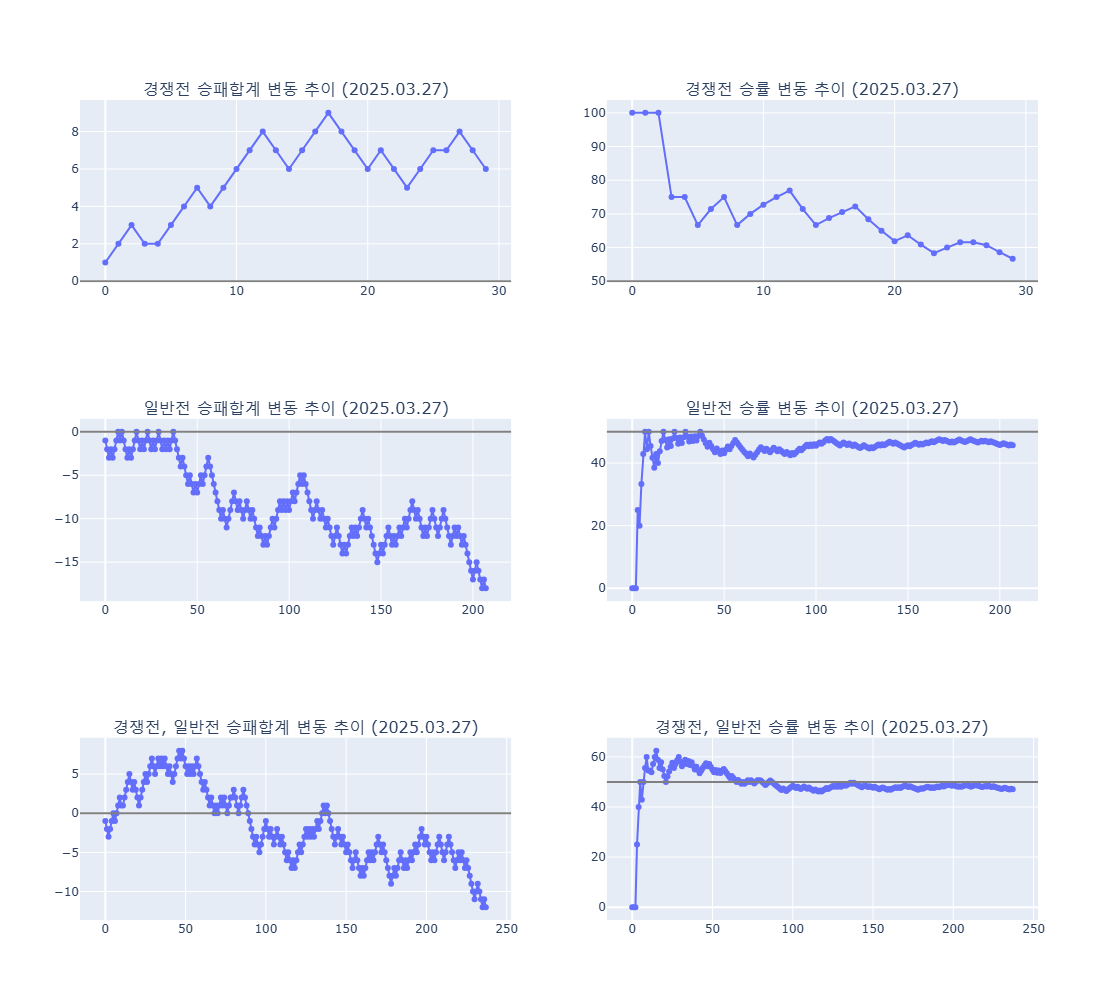

In [5]:
# 파일 가져오기
filename = "오버워치 승패 기록표.xlsx"
df = pd.read_excel(filename)

# 승: +1 패: -1 무: 0인 새 컬럼 생성
wlvalue = []
cnt=0
for i in df['승패'] :
    if i == '패' or i == '탈' :
        wlvalue.append(-1)
    elif i == '승' :
        wlvalue.append(1)
    elif i == '무':
        wlvalue.append(0)
    else :
        print("%d Index 행 승패 열에 오타 있음" %(cnt+1))
        break
    cnt += 1

df['wlvalue'] = wlvalue

###########################################################
# 전처리함수
# 매개변수 
#   df: 데이터
#   gamemode: rank/casual/rank_casual (일반/경쟁/경쟁+일반)
# 승패값(wlvalue) 컬럼 생성(승: +1, 패: -1, 무: 0)

def pre(df, gamemode) :

    if gamemode == 'rank' :
        df_gm = df[df['게임유형']=='경쟁']
    elif gamemode == 'casual' :
        df_gm = df[df['게임유형']=='빠대']
    elif gamemode == 'rank_casual' :
        df_gm = df[(df['게임유형']=='빠대')|(df['게임유형']=='경쟁')]
        df_gm = df_gm.reset_index().drop('index', axis=1)

    df_gm = df_gm.reset_index().drop('index', axis=1)
    # 승패합계(wlvalue) 컬럼 생성
    sum_wlvalue = []
    idx = 0
    for i in df_gm['wlvalue'] :
        sum_wlvalue.append(idx + i)
        idx = idx + i
    df_gm['sum_wlvalue'] = sum_wlvalue
    
    # 승률(winrate) 컬럼 생성
    winrate = []
    idx = 0
    win = 0
    los = 0
    tie = 0
    
    for i in range(0, len(df_gm)) :
        if df_gm['wlvalue'][i] == 0 :
            winrate.append(idx)
            tie += 1
        else :
            win = (df_gm['sum_wlvalue'][i]+i+1-tie)/2
            los = i+1-win-tie
            idx = round(win/(win+los+tie)*100, 2)
            winrate.append(idx)
    df_gm['winrate'] = winrate
    
    return df_gm
        
###################################################################
# 그래프 생성 함수
# 매개변수
#   df: 데이터
#   gamemode: rank/casual/rank_casual (일반/경쟁/일반+경쟁)
#   index: wlsum_prog/wrate_prog/wrate (승패합계추이/승률추이/승률)

def figure(df, gamemode, index) :
    # 그래프 생성 (전처리함수 호출)
    # 그래프 이름 생성 함수(config 종속성 있음)
    title_dic = {'rank_wlsum_prog': rank_wlsum_prog, 'rank_wrate_prog': rank_wrate_prog, 'rank_wrate': rank_wrate,
                 'casual_wlsum_prog': casual_wlsum_prog, 'casual_wrate_prog': casual_wrate_prog, 'casual_wrate': casual_wrate,
                 'rank_casual_wlsum_prog': rank_casual_wlsum_prog, 'rank_casual_wrate_prog': rank_casual_wrate_prog, 'rank_casual_wrate': rank_casual_wrate}
    title = title_dic[gamemode + '_' + index]

    index_dic ={'wlsum_prog': 'sum_wlvalue', 'wrate_prog': 'winrate'}
    # 그래프 그리기 함수
    df_gm = pre(df, gamemode)
    if index != 'wrate' :
        fig = px.line(data_frame= df_gm, x=df_gm.index, y=index_dic[index], markers=True, width = 1000, height = 400)
        fig.update_layout(title = title, title_x = 0.5, hovermode = 'x unified')
        fig.update_xaxes(showgrid=True, minor_showgrid=True, ticks='inside')
        fig.update_yaxes(showgrid=True, minor_showgrid=True, ticks='inside')
        if index == 'wlsum_prog' :
            fig.add_hline(y = 0, line_color = 'grey')
        elif index =='wrate_prog' :
            fig.add_hline(y = 50, line_color = 'grey')
        return fig
    # return() 썼을 때 문자열 합성 안 됨. 해결방법 찾아야 함
    elif index == 'wrate' :
        print(title, ':', len(df_gm[df_gm['승패']=='승'])/len(df_gm)*100)


##############################################################################################################
#############################################그래프 생성 및 저장##############################################
##############################################################################################################
fig = sp.make_subplots(rows=3, cols=2, subplot_titles=(rank_wlsum_prog, rank_wrate_prog, 
                                                       casual_wlsum_prog, casual_wrate_prog, 
                                                       rank_casual_wlsum_prog, rank_casual_wrate_prog))

fig_rank_wlsum_prog = figure(df, 'rank', 'wlsum_prog')
fig_rank_wrate_prog = figure(df, 'rank', 'wrate_prog')
fig_rank_wrate = figure(df, 'rank', 'wrate')

fig_casual_wlsum_prog = figure(df, 'casual', 'wlsum_prog')
fig_casual_wrate_prog = figure(df, 'casual', 'wrate_prog')
fig_casual_wrate = figure(df, 'casual', 'wrate')

fig_rank_casual_wlsum_prog = figure(df, 'rank_casual', 'wlsum_prog')
fig_rank_casual_wrate_prog = figure(df, 'rank_casual', 'wrate_prog')
fig_rank_casual_wrate = figure(df, 'rank_casual', 'wrate')

for trace in fig_rank_wlsum_prog.data :
    fig.add_trace(trace, row=1, col=1)
for trace in fig_rank_wrate_prog.data :
    fig.add_trace(trace, row=1, col=2)
for trace in fig_casual_wlsum_prog.data :
    fig.add_trace(trace, row=2, col=1)
for trace in fig_casual_wrate_prog.data :
    fig.add_trace(trace, row=2, col=2)
for trace in fig_rank_casual_wlsum_prog.data :
    fig.add_trace(trace, row=3, col=1)
for trace in fig_rank_casual_wrate_prog.data :
    fig.add_trace(trace, row=3, col=2)

# 호버모드, 수평선 설정 다시 해 줘야 함
fig.update_layout(width = 1200, height = 1000, hovermode = 'x unified')
fig.add_hline(y = 0, line_color = 'grey', col = 1)
fig.add_hline(y = 50, line_color = 'grey', col = 2)

fig.show()

# 저장
fig.update_layout(width = 1600, height = 1300)
fig.write_html('오버워치 승패 분석 %s.html' %today)